In [686]:
import matplotlib.pyplot as plt
import pandas as pd
import os
import numpy as np
import time
from scipy.signal import find_peaks

In [709]:
data_path  = r'C:\Users\lhauptmann\Code\WristPPG2\data'
save_dir = r'C:\Users\lhauptmann\Code\WristPPG2\data\dataset'
index = 1021
participant_name = "ppgsmall_3"

imu_file = f"imu_{index:03d}.txt"
ppg_file = f"ppg_{index:03d}.txt"
label_file = f"labels//label_{index:03d}.csv"

LETTER_GESTURES = {
    "a": "Swipe Forward",
    "b": "Swipe Backward",
    "c": "Swipe Left",
    "d": "Swipe Right",
    "p": "Fast Pinch",
    "prr": "Rotate Right",
    "prl": "Rotate Left",
    "pbd": "Back to Default",
    "pc": "Pinch Hold",
    "po": "Pinch Open",
    "sp": "Side Pinch",
    "o": "Nothing",
    "s": "Knock"
}

sampling_rate = 112.22

In [710]:

def read_ppg_csv(data_file, columns = None):
    df = pd.read_csv(data_file, skiprows=32, skipfooter=5, usecols=[0]+list(range(34,69)))
    df["timestamp"] = df["timestamp"] / 1000
    df[["ACCX", "ACCY", "ACCZ"]] = df[["ACCX", "ACCY", "ACCZ"]] / 1000
    
    if columns is not None:
        df.rename(columns={col:el for i,(el, col) in enumerate(zip(columns, df.columns))}, inplace=True)
        
    # read all lines in the file
    with open(data_file, "r") as f:
        lines = f.readlines()
    start_time, end_time = None, None    
    for line in lines:
        if line.startswith("start time"):
            start_time = float(line.split(",")[-1])
        if line.startswith("stop time"):
            end_time = float(line.split(",")[-1])
    
    return df, start_time, end_time

def read_txt_data(data_file, n_features = 9, columns = None):

    data = open(data_file, "r").read()

    rows = data.strip().split("\n")

    def pad_to_longest(package_dict, padding_value=0):
        longest = max([len(v) for v in package_dict.values()])
        for k in package_dict.keys():
            if len(package_dict[k]) < longest:
                #print(f"Padding {k} with {longest - len(package_dict[k])} values")
                package_dict[k] += [padding_value] * (longest - len(package_dict[k]))
        return package_dict

    def update_dict(data_dict, package_dict, package_id=None):
        
        if package_id is not None:
            package_dict["package_id"] = [package_id] * len(package_dict[0])
        
        for k in package_dict.keys():
            data_dict[k].extend(package_dict[k])
        return data_dict


    data_dict = {k:[] for k in range(0,n_features)}
    data_dict["package_id"] = []
    package_dict = {k:[] for k in range(0,n_features)}
    # Loop over each row
    package_id = 0
    previous_key = 100
    start_time = 0
    end_time = 0
    for row in rows:
        if row.startswith('start time'):
            start_time = float(row.split(":")[-1])
            continue
        if row.startswith('end time'):
            end_time = float(row.split(":")[-1])
            continue
        # Split the row by spaces and convert each entry to an integer
        row_split = row.split(" ")
        key = int(row_split[0])  
        data_values = [float(el) for el in row_split[1:] if el != ""]
        if key < previous_key: # next package
            package_dict = pad_to_longest(package_dict, padding_value=np.nan)
            data_dict = update_dict(data_dict, package_dict, package_id)
            package_dict = {k:[] for k in range(0,n_features)}
            package_id += 1
        package_dict[key].extend(data_values)
        previous_key = key
    #data_dict = pad_to_longest(data_dict, padding_value=np.nan)
    df_data = pd.DataFrame(data_dict)
    if columns is not None:
        df_data.rename(columns={i:el for i,el in enumerate(columns)}, inplace=True)
    return df_data, start_time, end_time


In [711]:
ppg_columns = [ "ppg_green_1", "ppg_green_2", "ppg_green_3", "ppg_green_4", "ppg_green_5", "ppg_green_6", "ppg_green_7", "ppg_green_8",
               #"ppg_ir_1", "ppg_ir_2","ppg_ir_3", "ppg_ir_4","ppg_ir_5", "ppg_ir_6","ppg_ir_7", "ppg_ir_8", 
               "ppg_red_1", "ppg_red_2","ppg_red_3", "ppg_red_4","ppg_red_5", "ppg_red_6","ppg_red_7", "ppg_red_8", 
               #"ppg_amb_1", "ppg_amb_2","ppg_amb_3", "ppg_amb_4","ppg_amb_5", "ppg_amb_6","ppg_amb_7", "ppg_amb_8", 
               "acc_ppg_x", "acc_ppg_y", "acc_ppg_z", "timestamp"]

#df_ppg, ppg_start, ppg_end = read_txt_data(os.path.join(data_path, ppg_file), n_features=36, columns = ppg_columns)
df_ppg, ppg_start, ppg_end = read_txt_data(os.path.join(data_path, ppg_file), n_features=20,columns = ppg_columns)

ppg_acc_factor = 4 if index < 8 else 1
df_ppg[["acc_ppg_x", "acc_ppg_y", "acc_ppg_z"]] = df_ppg[["acc_ppg_x", "acc_ppg_y", "acc_ppg_z"]] * ppg_acc_factor
labels = pd.read_csv(os.path.join(data_path, label_file))
#print(f"Time of Recording: {time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(ppg_start))}")
df_ppg.interpolate(inplace=True)

In [712]:
# setting the ppg timestamp based| on the package ids , every package is every 2 seconds
current_package_timestamp = ppg_start
current_timestamp = ppg_start

df_ppg["timestamp"] = 0
current_package_id = df_ppg["package_id"].iloc[0]
for i, row in df_ppg.iterrows():
    if row["package_id"] != current_package_id:
        current_package_id = row["package_id"]
        current_package_timestamp += 2.0045#2.004 # should be 2, but empirically found to be 2.004
        current_timestamp = current_package_timestamp
    else:
        current_timestamp += 1/sampling_rate
    df_ppg.at[i, "timestamp"] = current_timestamp
    
while (df_ppg["timestamp"].diff() < 0).any():
    df_ppg = df_ppg[df_ppg["timestamp"].diff() >= 0]

C:\Users\lhauptmann\AppData\Local\Temp\ipykernel_1436\4054842028.py:14: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1730222622.42433' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_ppg.at[i, "timestamp"] = current_timestamp


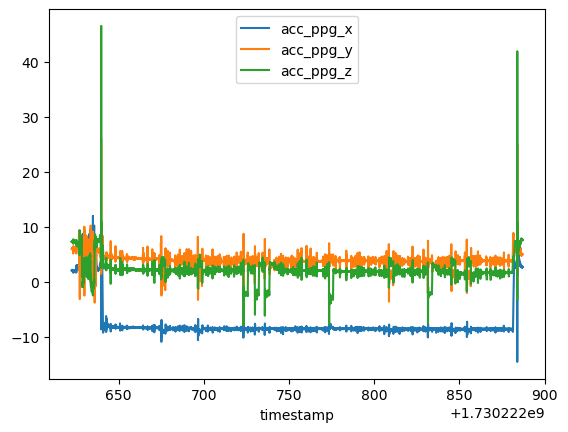

In [713]:

ax = df_ppg.plot(y=["acc_ppg_x", "acc_ppg_y", "acc_ppg_z"], x ="timestamp")


In [714]:
df_ppg.set_index("timestamp", inplace=True)


In [715]:

calibration_peaks_ppg = find_peaks((df_ppg["acc_ppg_z"] - df_ppg["acc_ppg_z"].mean()).abs(), height=10, prominence=5, distance=100)[0]
calibration_peaks_ppg

array([ 1935, 29223], dtype=int64)

[ 1935 29223] timestamp
1.730223e+09    46.526074
1.730223e+09    41.913184
Name: acc_ppg_z, dtype: float64


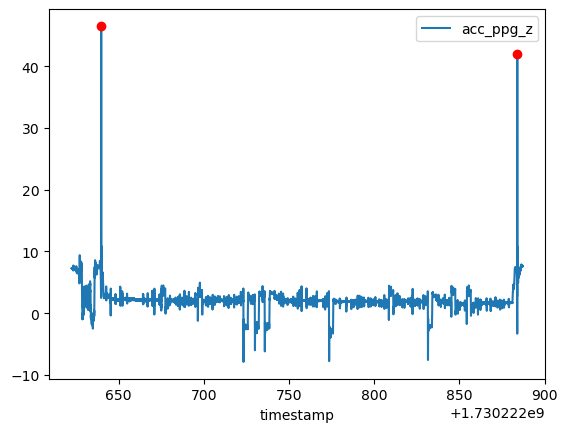

In [716]:
# plot acc_ppg_z with peaks
df_ppg.plot(y=["acc_ppg_z"])
plt.plot(df_ppg.iloc[calibration_peaks_ppg]["acc_ppg_z"], "ro")
print(calibration_peaks_ppg, df_ppg.iloc[calibration_peaks_ppg]["acc_ppg_z"])

In [719]:
start_peak_id = 0
end_peak_id = -1

In [720]:
ppg_length = df_ppg.iloc[calibration_peaks_ppg[start_peak_id]].name - df_ppg.iloc[calibration_peaks_ppg[end_peak_id]].name
label_length = labels[labels["label"] == "s"]["start_time"].diff().iloc[-1]
ppg_length, label_length

(-244.13016605377197, 244.19360160827637)

In [721]:
labels_calibration_start_time = labels[labels["label"] == "s"].iloc[0]["start_time"]
labels_calibration_end_time = labels[labels["label"] == "s"].iloc[-1]["start_time"]
offset = labels_calibration_start_time - df_ppg.iloc[calibration_peaks_ppg[start_peak_id]].name
time_stretch = 1 #abs(label_length / ppg_length)
labels_re = labels.copy()
labels_re[["start_time", "end_time"]] = (labels_re[["start_time", "end_time"]] - labels_calibration_start_time)/time_stretch + labels_calibration_start_time - offset



In [722]:
df_all = df_ppg

<Axes: xlabel='timestamp'>

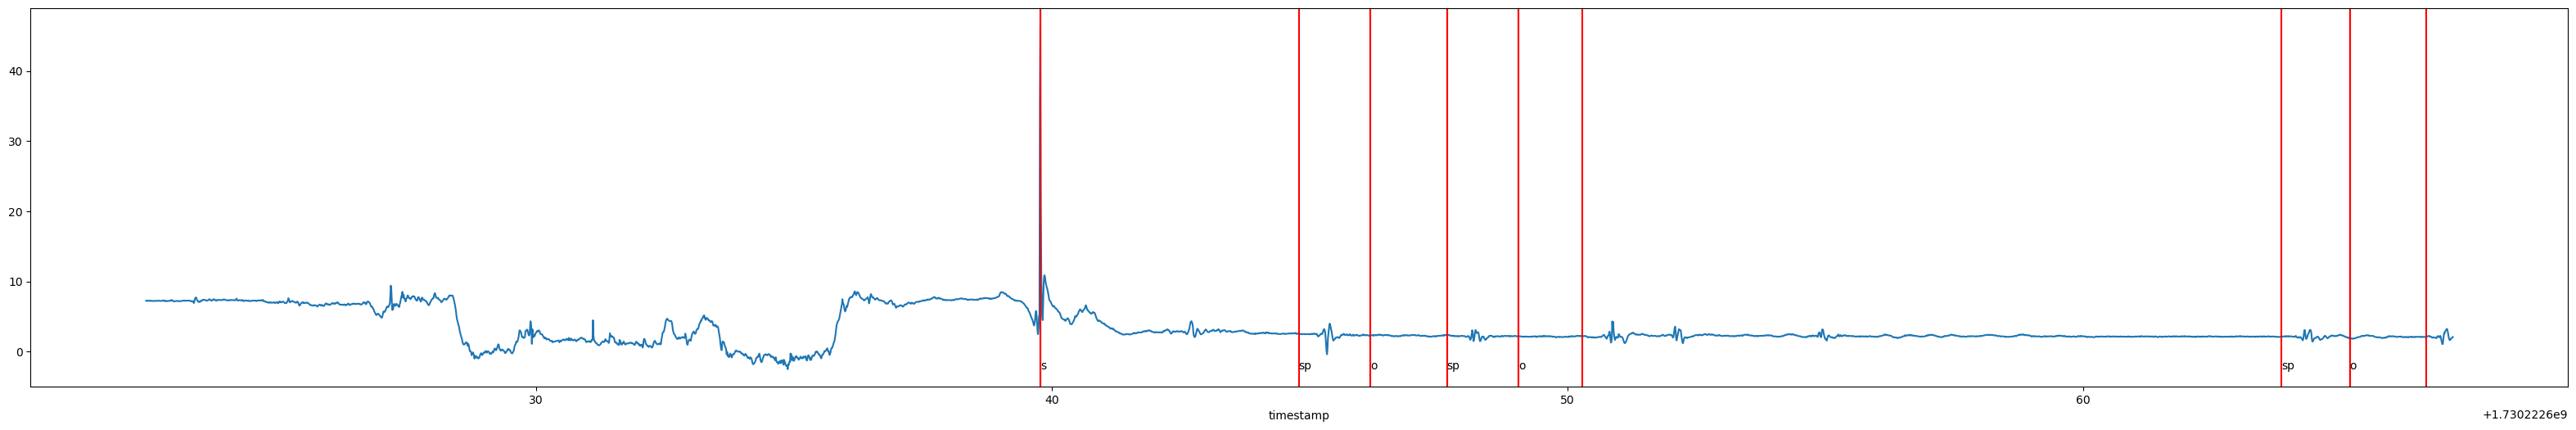

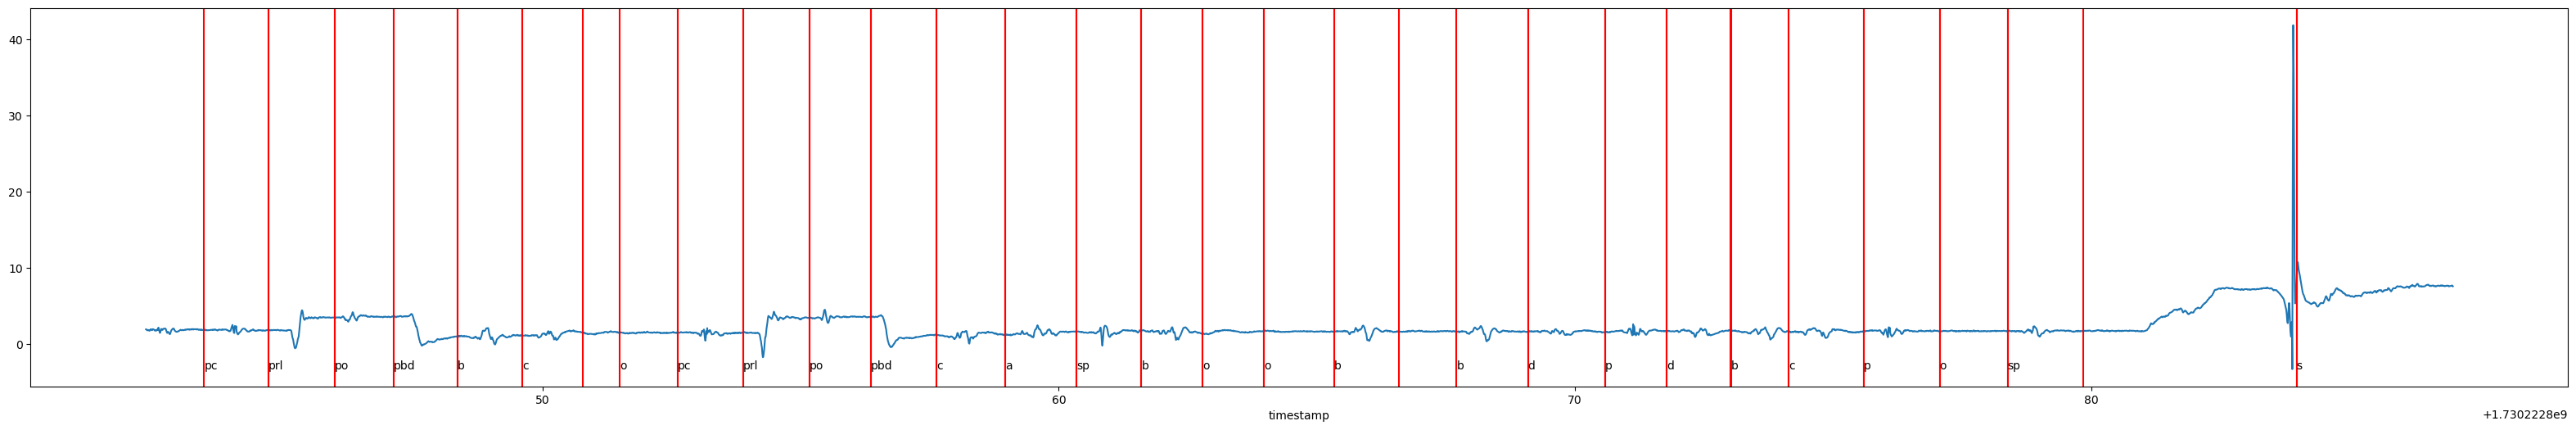

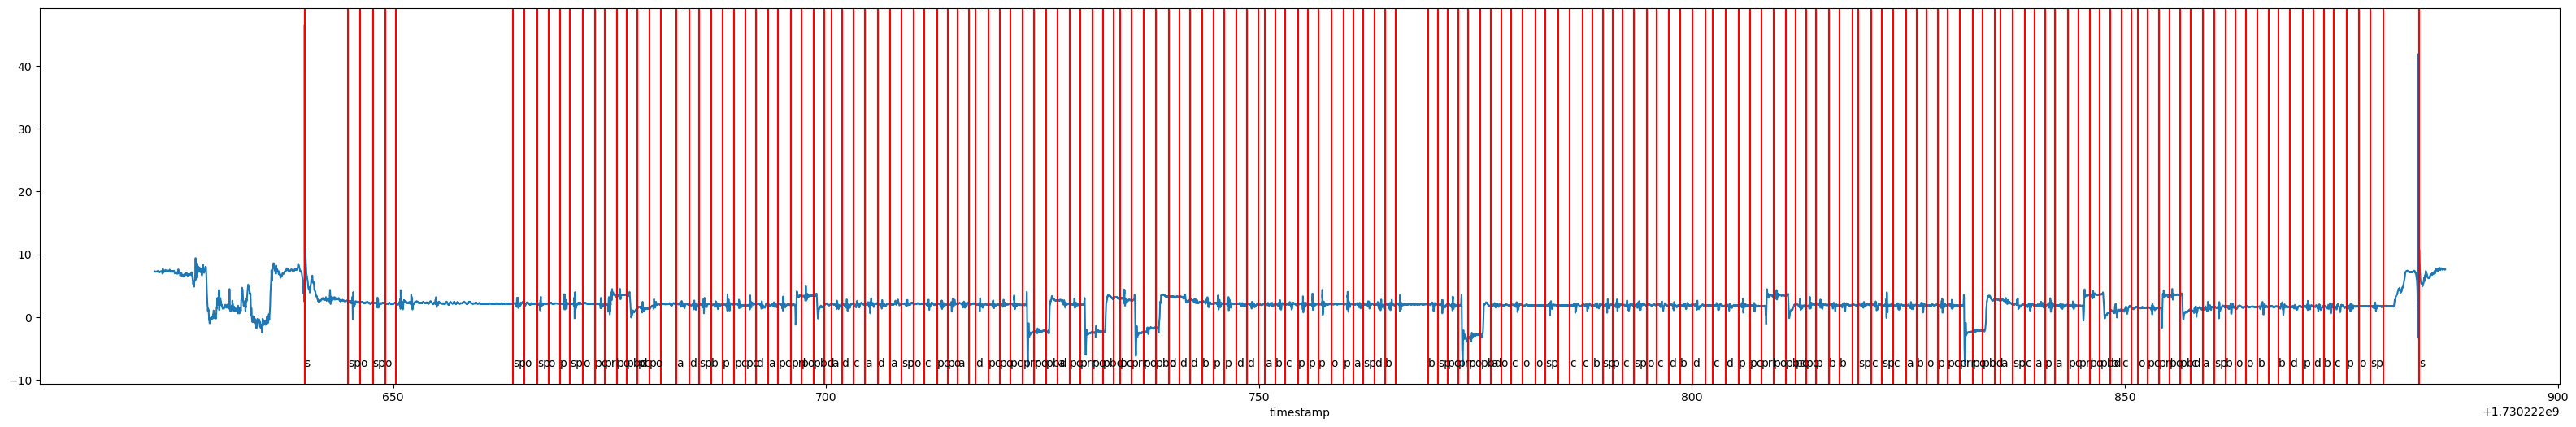

In [723]:

def plot_with_labels(df ,labels):
    fig, ax = plt.subplots(figsize=(40, 6))
    df.plot(ax=ax)
    df_min = df.min().min() if isinstance(df, pd.DataFrame) else df.min()
    x_range = [df.index[0], df.index[-1]]
    for index, row in labels.iterrows():
        if row["start_time"] < x_range[0] or row["end_time"] > x_range[1]:
            continue
        ax.axvline(x=row["start_time"], color='r')
        ax.axvline(x=row["end_time"], color='r')
        ax.text(row["start_time"] , df_min, row["label"], rotation=0)
    return ax

plot_with_labels(df_all["acc_ppg_z"].iloc[:5000], labels_re)
plot_with_labels(df_all[ "acc_ppg_z"].iloc[-5000:], labels_re)
plot_with_labels(df_all[ "acc_ppg_z"], labels_re)
        

In [724]:
row = labels_re.iloc[1]
row

label_start = df_all.index[df_all.index > row["start_time"]]
label_start = label_start[0] if len(label_start) > 0 else df_all.index[-1]

label_end = df_all.index[df_all.index > row["end_time"]]
label_end = label_end[0] if len(label_end) > 0 else df_all.index[-1]

label_start, label_end, df_all.index.get_loc(label_end), df_all.index.get_loc(label_start)

(1730222644.7946298, 1730222646.1847665, 2653, 2497)

In [725]:
labels_index = labels_re.copy()

for i, row in labels_re.iterrows():
    label_start = df_all.index[df_all.index > row["start_time"]]
    label_start = label_start[0] if len(label_start) > 0 else df_all.index[-1]
    labels_index.at[i, "start_index"] = df_all.index.get_loc(label_start)
    label_end = df_all.index[df_all.index > row["end_time"]]
    label_end = label_end[0] if len(label_end) > 0 else df_all.index[-1]
    labels_index.at[i, "end_index"] = df_all.index.get_loc(label_end)
labels_index[["start_index", "end_index"]] = labels_index[["start_index", "end_index"]].astype(int)


In [726]:
df_all.reset_index(inplace=True)

assert (labels_index["start_index"] > 0).all()
assert (labels_index["end_index"] < len(df_all)).all()

In [727]:
import h5py

def save_to_hdf5(df_all, labels_df, output_file):
    # Read the labels from a CSV or pandas dataframe

    # Open an HDF5 file
    with h5py.File(output_file, 'w') as hdf5_file:
        # Iterate over each row of the dataframe
        for idx, row in labels_df.iterrows():
            label = row['label']
            start_index = row['start_index']
            end_index = row['end_index']
            start_time = row['start_time']
            end_time = row['end_time']

            # Create a group named 'Label_Timestamp' (label + index)
            group_name = f"{label}_{int(start_time*1000)}"
            label_group = hdf5_file.create_group(group_name)

            # Save the start and end indexes as datasets in the group
            label_group.create_dataset('start_index', data=start_index)
            label_group.create_dataset('end_index', data=end_index)
            label_group.create_dataset('label', data=label)
            label_group.create_dataset('start_time', data=start_time)
            label_group.create_dataset('end_time', data=end_time)
        
        data_group = hdf5_file.create_group("data")
        for column in df_all.columns:
            data_group.create_dataset(column, data=df_all[column].values)

            

    print(f"Labels saved to {output_file}")
    

save_path = os.path.join(save_dir, "participant_"+ participant_name.split("_")[0], f"participant_{participant_name}.hdf5")
os.makedirs(os.path.dirname(save_path), exist_ok=True)
save_to_hdf5(df_all, labels_index, save_path)

Labels saved to C:\Users\lhauptmann\Code\WristPPG2\data\dataset\participant_ppgsmall\participant_ppgsmall_3.hdf5
